In [1]:
%matplotlib widget
#%matplotlib inline
import numpy as np
import json, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.YAG_scans import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import *
import glob
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [2]:
pgroup='p20537'
runnumber = 196
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0196


'/sf/alvra/data/p20537/raw/run0196-mono_scan_2500eV/meta/scan.json'

In [10]:
fc = FileChooser('/sf/alvra/data/p20537/raw')  #this is for RC
fc.use_dir_icons = True

display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [11]:
jsonfile = copy.copy(fc.selected)
jsonfile

'/gpfs/photonics/swissfel/raw/alvra-staff/p20537/run0194-mono_scan_2500eV/meta/scan.json'

In [3]:
quantile_band = 0.5

#channel_list = [channel_Izero117, channel_Izero122]#, channel_PSSS_y, channel_PSSS_x]
channel_list = [channel_Izero110]#, channel_PSSS_y, channel_PSSS_x]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
Energy_eV = scan.readbacks

PIPS = []
Izero110 = []
Izero122 = []
NormPSSS = []
Spectrum_PSSS = []
PSSS_eV =[]

Signal_110 = []
Signal_122 = []

#for i in range(len(scan.files)):
#    step = scan[i]
for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Processing: {}'.format(jsonfile.split('/')[-3]))
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results, _ = load_data_compact(channel_list, step)
    Izero110_shot = results[channel_Izero110]
#    Izero122_shot = results[channel_Izero122]
#    PSSS_shot = results[channel_PSSS_y]#.mean(axis = 0)
#    PSSS_eV = results[channel_PSSS_x].mean(axis = 0)

    df_Izero110 = pd.DataFrame(Izero110_shot)
    Izero110.append(np.quantile(df_Izero110, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

#    df_Izero122 = pd.DataFrame(Izero122_shot)
#    Izero122.append(np.quantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

#    PSSS_integral = np.mean(PSSS_shot, axis = 1)
#    df_NormPSSS = pd.DataFrame(PSSS_integral)
#    NormPSSS.append(np.quantile(df_NormPSSS, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    df_signal_norm = pd.DataFrame(Izero110_shot)# / PSSS_integral)
    Signal_110.append(np.quantile(df_signal_norm, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
#    df_signal122_norm = pd.DataFrame(df_Izero122)# / PSSS_integral)
#    Signal_122.append(np.quantile(df_signal122_norm, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

#    Spectrum_PSSS.append(PSSS_shot.mean(axis = 0))
    
Energy_eV = Energy_eV[:len(Signal_110)]
    
#Spectrum_PSSS = np.asarray(np.mean(Spectrum_PSSS, axis = 0))
PSSS_eV = np.asarray(PSSS_eV)
#NormPSSS = np.asarray(NormPSSS)
Izero110 = np.asarray(Izero110)
Izero122 = np.asarray(Izero122)
PIPS = np.asarray(PIPS)

Signal_110 = np.asarray(Signal_110)
Signal_122 = np.asarray(Signal_122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))


Processing: run0196-mono_scan_2500eV
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 248 / 251 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 248 / 251 -> 1% loss
complete channels: 1 / 2 -> 50% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.25,0.75


In [36]:
# Normalization with the PSSS integral

Signal_110_norm = Signal_110 #Izero117 / NormPSSS
Signal_122_norm = Signal_122 #Izero122 / NormPSSS

Int_110 = Signal_110_norm[:,0]
err_low_110 = Signal_110_norm[:,1]
err_high_110 = Signal_110_norm[:,2]

#Int_122 = Signal_122_norm[:,0]
#err_low_122 = Signal_122_norm[:,1]
#err_high_122 = Signal_122_norm[:,2]

# No normalization 

#Signal_norm = Izero117

NameError: name 'Int_110' is not defined

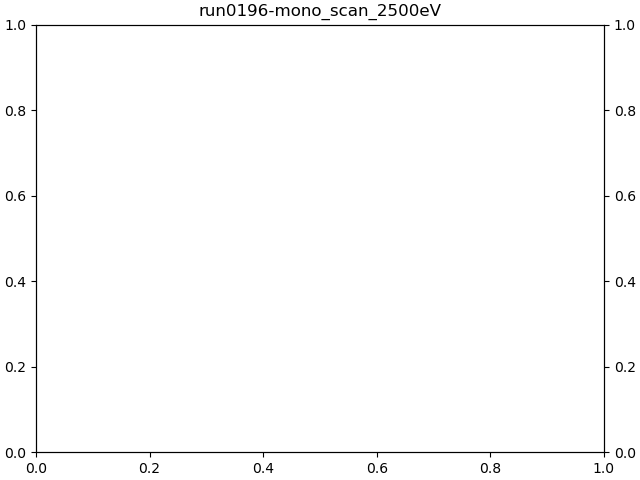

In [5]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax2 = ax1.twinx()
plt.title(jsonfile.split('/')[-3])

#ax2.plot(PSSS_eV, Spectrum_PSSS, label='PSSS avg spectrum', color = 'coral')
ax1.plot(Energy_eV, Int_110, label='{}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Energy_eV, err_low_110, err_high_110, color='lightblue')

#ax1.plot(Energy_eV, Int_122, label='monochromator {}%'.format(quantile_band*100),marker='.')
#ax1.fill_between(Energy_eV, err_low_122, err_high_122, color='lightblue')

#ax2.plot(energy_vonHamos, spectrum_vonHamos, label='von Hamos', color = 'coral')
#ax2.set_xlim(3000, 3050)


ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("mono")
#ax2.set_ylabel("von Hamos")
ax1.legend(loc="best")
#ax2.legend(loc="upper left")

ax1.grid()

plt.show()

#plt.savefig(savedir+'/spectrum_compare.png')

In [38]:
spectrum_toFit = np.copy(Signal_110_norm[:,0])
Energy_eV_toFit = np.copy(Energy_eV)

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Energy_eV_toFit, spectrum_toFit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Energy_eV_toFit,spectrum_toFit)                  # calculate the fit
spectrum_fit = fit.eval(Energy_eV_toFit)            # evaluate the curve for plotting

center = fit.popt[0]
width = fit.popt[2]*2.355

#index = ~(np.isnan(Energy_eV_toFit) | np.isnan(spectrum_toFit))

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)

Center wavelength = 2511.473 eV
Width = 16.126 eV
Bandwidth = 0.6420933054028453 %


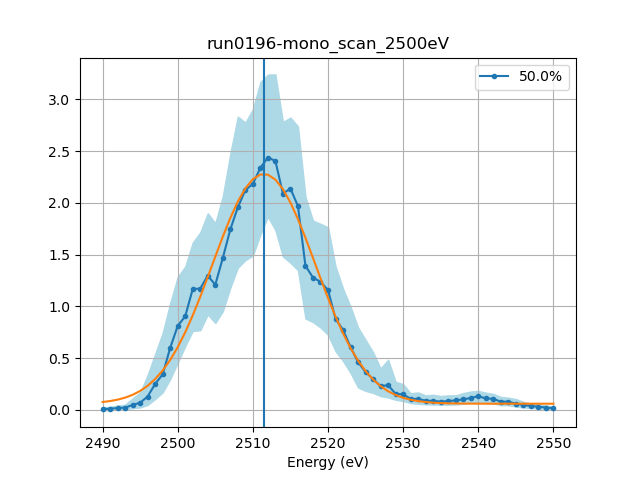

Center wavelength = 2511.473 eV
Width = 16.126 eV
Bandwidth = 0.6420933054028453 %


In [39]:
plt.figure()

plt.plot(Energy_eV, Int_110, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low_110, err_high_110, color='lightblue')

plt.plot(Energy_eV_toFit, spectrum_fit)

plt.title(jsonfile.split('/')[-3])
plt.grid()
plt.xlabel("Energy (eV)")
plt.legend(loc="best")

plt.axvline(x=center)

plt.show()

print("Center wavelength =",np.round(center,3),"eV")
print("Width =",np.abs(np.round(width,3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))
